In [67]:
import os
import diplib as dip
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2


# --- Configuration (adjust these paths) ---
input_dir  = r"2023Assignment05Images"
output_dir = r"output"
os.makedirs(output_dir, exist_ok=True)

# --- Selected final dataset of each embryo ---
final_datset = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21b", # instead of 20
    "22",
    "23",
    "24", # instead of 24b
    "25",
    "26b", # instead of 26
    "27",
    "28",
    "29",
    "30",
    "31",
    "32b", # instead of 32
    "33",
    "34b", # instead of 34
    "35b", # instead of 35
    "36", # instead of 36b
    "37",
    "38b", # instead of 38
    "39",
    "40",
    "41", # instead of 41b
    "42",
    "43", # instead of 43b
    "44",
    "45b", # instead of 45
    "46", # instead of 46b and 46c
    "47", # instead of 47b
    "48",
    "49",
    "50", # instead of 50b
    "51",
    "52",
    "53", # instead of 53 flipped
    "54", # instead of 54b
    "55",
    "56b", # instead of 56
    "57",
    "58" # instead of 58b
]

img_paths = [os.path.join(input_dir, f"w8t1t2_d7_{num}.tif") for num in final_datset]


# Part 1

Original


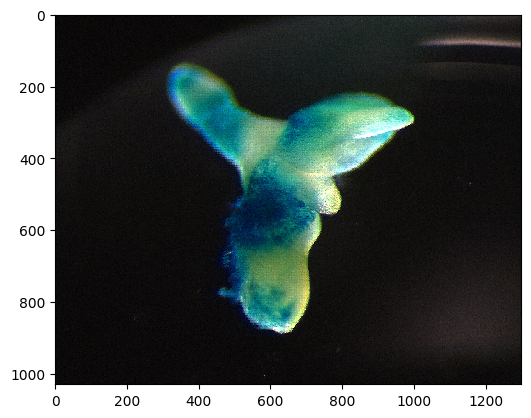

Blue channel


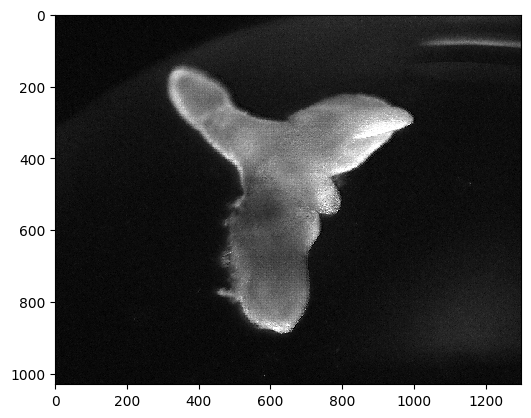

Blue channel clipped to 18000


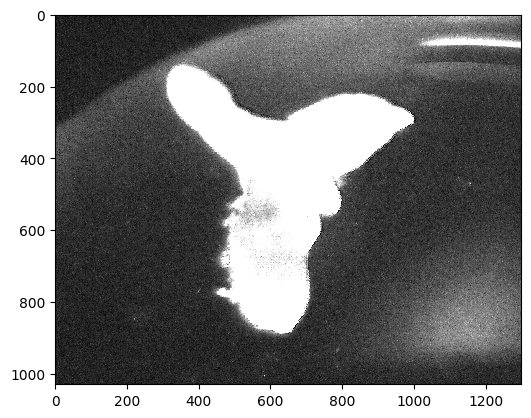

Gray scale opening to remove noise


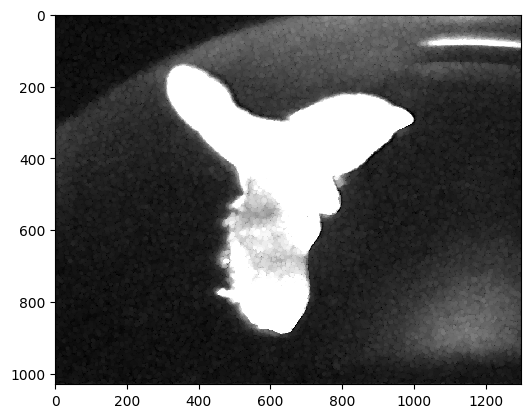

Threshold on blue channel


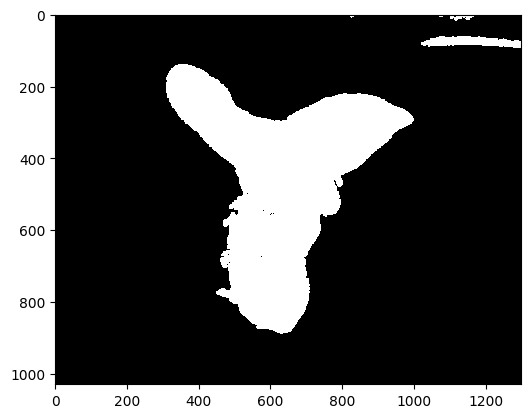

Fill larger holes left


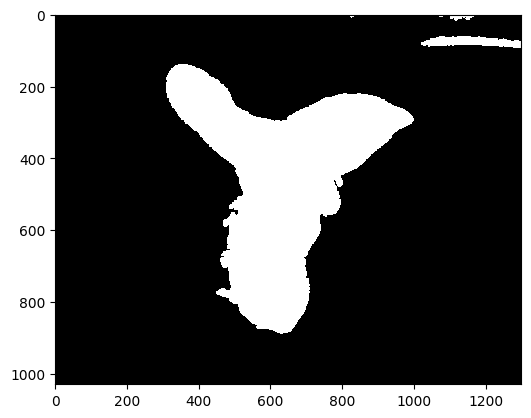

Opening to remove connecting objects


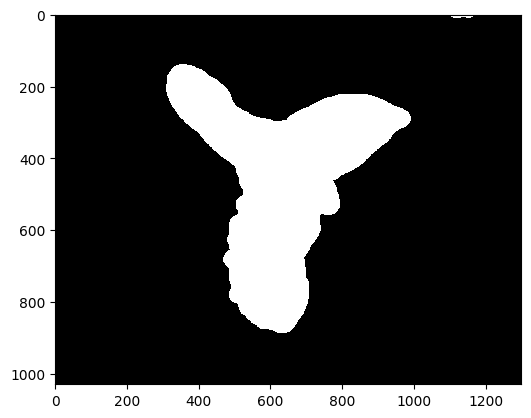

Binary mask of largest object


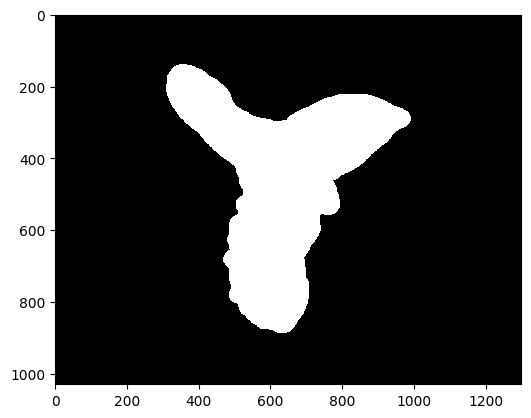

In [58]:
# -----------------------------------------------------
# Q1.1: Segmentation technique to prepare the embryos
# -----------------------------------------------------

def embryo_segmentaion(img_path, show_intermediates=False):
    img = dip.ImageRead(img_path)
    if show_intermediates:
        print("Original")
        img.Show()
    
    # Extract blue channel
    img_blue = img(2)
    if show_intermediates:
        print("Blue channel")
        img_blue.Show()
    # Clip upper blue intensity value
    clip_value = 18000
    img_blue = dip.ClipHigh(img_blue, clip_value)
    if show_intermediates:
        print(f"Blue channel clipped to {clip_value}")
        img_blue.Show()

    # Gray scale openeing to remove noise
    img_blue = dip.Opening(img_blue, dip.SE((10,10), "elliptic"))
    if show_intermediates:
        print("Gray scale opening to remove noise")
        img_blue.Show()

    # Threshold on the blue channel
    img_bin = dip.OtsuThreshold(img_blue)
    if show_intermediates:
        print("Threshold on blue channel")
        img_bin.Show()

    # Fill larges holes left in the embryo
    img_bin = dip.FillHoles(img_bin, connectivity=2)
    if show_intermediates:
        print("Fill larger holes left")
        img_bin.Show()

    # Opening to remove connecting objects
    img_bin = dip.Opening(img_bin, dip.SE((50,50)))
    if show_intermediates:
        print("Opening to remove connecting objects")
        img_bin.Show()


    # Label remaining objects
    img_lbl = dip.Label(img_bin)
    # Measure object sizes
    m = dip.MeasurementTool.Measure(img_lbl, img, ["Size"])
    # Derive largest object
    largest_lbl = np.argmax(m["Size"]) + 1

    # Create the binary image mask for the largest object
    embryo_mask = img_lbl == largest_lbl
    if show_intermediates:
        print("Binary mask of largest object")
        embryo_mask.Show()

    return img, embryo_mask


# -----------------------------------------------------
# Q1.2 + Q1.3: Resize image for use in report
# -----------------------------------------------------

def rescale_image(img, scalar = 0.25):
    new_img = dip.Resampling(img, zoom=scalar)
    return new_img

def write_rescaled_images(img_path, img, embryo_mask):
    rescale_img = rescale_image(img)
    rescale_embryo_mask = rescale_image(embryo_mask)

    rescale_img_dir = os.path.join(output_dir, "rescale_img")
    rescale_embryo_mask_dir = os.path.join(output_dir, "rescale_embryo_mask")
    os.makedirs(rescale_img_dir, exist_ok=True)
    os.makedirs(rescale_embryo_mask_dir, exist_ok=True)

    rescale_img_path = os.path.join(rescale_img_dir, Path(img_path).stem)
    rescale_embryo_mask_path = os.path.join(rescale_embryo_mask_dir, Path(img_path).stem)

    dip.ImageWritePNG(rescale_img, rescale_img_path)
    dip.ImageWritePNG(rescale_embryo_mask, rescale_embryo_mask_path)

for img_path in img_paths:
    img, embryo_mask = embryo_segmentaion(img_path)
    write_rescaled_images(img_path, img, embryo_mask)

img, embryo_mask = embryo_segmentaion(img_paths[53], show_intermediates=True)


# Part 2

In [63]:
# -----------------------------------------------------
# Q2.1: Compute size and shape features
# -----------------------------------------------------

def convert_to_uint8(img):
    # Compute robust intensity range using percentiles
    minimum, maximum = dip.MaximumAndMinimum(img)
    
    # Linearly rescale to 0-255 range and clip outliers
    img = (img - minimum) * (255.0 / (maximum - minimum ))
    img = dip.Clip(img, 0, 255)
    
    return dip.Convert(img, 'UINT8')

def highlight_blue_regions(img):
    # Subtract red and green channels from blue channel
    img_blue_only = img(2) - img(1) - img(0)
    img_blue_only = convert_to_uint8(img_blue_only)
    return img_blue_only

shape_results = []
for img_path in img_paths:
    img_id = Path(img_path).stem
    img, embryo_mask = embryo_segmentaion(img_path)
    img_blue_only = highlight_blue_regions(img)
    m = dip.MeasurementTool.Measure(dip.Label(embryo_mask), img_blue_only,
                                    ["Size", "Perimeter", "Roundness", "Solidity", "Mass", "Mean"])
    shape_results.append(
        {
            "Image_ID": img_id,
            "Area": m[1]["Size"][0],
            "Perimeter": m[1]["Perimeter"][0],
            "Roundness": m[1]["Roundness"][0],
            "Solidity": m[1]["Solidity"][0],
            "Blue_Absolute": m[1]["Mass"][0],
            "Blue_Relative": m[1]["Mean"][0]
        }
    )
shape_features_df = pd.DataFrame(shape_results)
shape_features_df = shape_features_df.set_index("Image_ID")
shape_features_df.to_latex(os.path.join(output_dir, "shape_features.tex"), float_format="%.3f")
display(shape_features_df)

# -----------------------------------------------------
# Q2.2: Establish three groups in plant embryos
# -----------------------------------------------------

scaler = StandardScaler()
scaled_features = scaler.fit_transform(shape_features_df)
scaled_df = pd.DataFrame(scaled_features,
                         columns=shape_features_df.columns,
                         index=shape_features_df.index)

kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df["Group"] = kmeans.fit_predict(scaled_features)
shape_features_df["Group"] = scaled_df["Group"]

# Create a DataFrame mapping groups to image IDs
group_images = shape_features_df.groupby('Group').apply(lambda x: ', '.join(x.index), include_groups=False)
group_table = pd.DataFrame({
    'Group': group_images.index,
    'Image IDs': group_images.values,
    'Count': shape_features_df.groupby('Group').size()
}).set_index('Group')
group_table.to_latex(os.path.join(output_dir, "group_table.tex"), float_format="%.3f")
display(group_table)

group_stats = shape_features_df.groupby('Group').agg(['mean', 'std'])
group_stats.to_latex(os.path.join(output_dir, "group_stats.tex"), float_format="%.3f")

display(group_stats)

,Area,Perimeter,Roundness,Solidity,Blue_Absolute,Blue_Relative
Image_ID,,,,,,
w8t1t2_d7_01,17063.627947,908.343844,0.259885,0.623521,36618096.0,150.227470
w8t1t2_d7_02,20224.953950,804.549126,0.392638,0.682655,43049271.0,149.005818
w8t1t2_d7_03,16644.371953,805.115069,0.322672,0.640924,25063650.0,105.414869
w8t1t2_d7_04,26402.136936,968.071680,0.354025,0.690036,69649835.0,184.674095
w8t1t2_d7_05,15987.241211,720.959313,0.386511,0.673805,30546046.0,133.753896
w8t1t2_d7_06,15597.877070,816.018813,0.294357,0.686461,33366030.0,149.749027
w8t1t2_d7_07,18541.209557,693.966521,0.483806,0.811276,33444776.0,126.274366
w8t1t2_d7_08,12093.319787,691.270946,0.318023,0.656325,20803686.0,120.425850
w8t1t2_d7_09,18022.897422,764.733038,0.387271,0.757428,31955408.0,124.120845


,Image IDs,Count
Group,,
0,"w8t1t2_d7_01, w8t1t2_d7_04, w8t1t2_d7_17, w8t1...",9
1,"w8t1t2_d7_03, w8t1t2_d7_08, w8t1t2_d7_16, w8t1...",17
2,"w8t1t2_d7_02, w8t1t2_d7_05, w8t1t2_d7_06, w8t1...",32


Area                Perimeter            Roundness            \
               mean          std        mean        std      mean       std   
Group                                                                         
0      20737.642403  3081.357130  919.402281  29.061641  0.307616  0.037410   
1      13123.141283  2493.317242  769.009281  98.881669  0.280887  0.039741   
2      16783.562458  2172.414876  759.378235  57.718481  0.367573  0.045648   

       Solidity           Blue_Absolute               Blue_Relative             
           mean       std          mean           std          mean        std  
Group                                                                           
0      0.651986  0.037763  4.891874e+07  1.168440e+07    163.327476  15.840679  
1      0.581469  0.076779  2.297871e+07  6.870963e+06    121.125437  23.905280  
2      0.699901  0.052802  3.714144e+07  6.182820e+06    154.839260  14.739773

# Part 3

,Uniformity_Blue,Uniformity_Remain,Std_Blue,Std_Remain
Image_ID,,,,
w8t1t2_d7_01,0.028913,0.007274,14.658727,47.330172
w8t1t2_d7_02,0.016116,0.010863,20.005330,35.670844
w8t1t2_d7_03,0.013022,0.007544,21.415317,53.509870
w8t1t2_d7_04,0.023006,0.008553,14.636542,36.039500
w8t1t2_d7_05,0.012318,0.009999,22.321120,32.194727
w8t1t2_d7_06,0.016417,0.010049,23.034522,38.272968
w8t1t2_d7_07,0.015072,0.008045,18.216564,39.413623
w8t1t2_d7_08,0.016432,0.007869,18.548380,42.102923
w8t1t2_d7_09,0.024909,0.007612,16.981892,42.777765


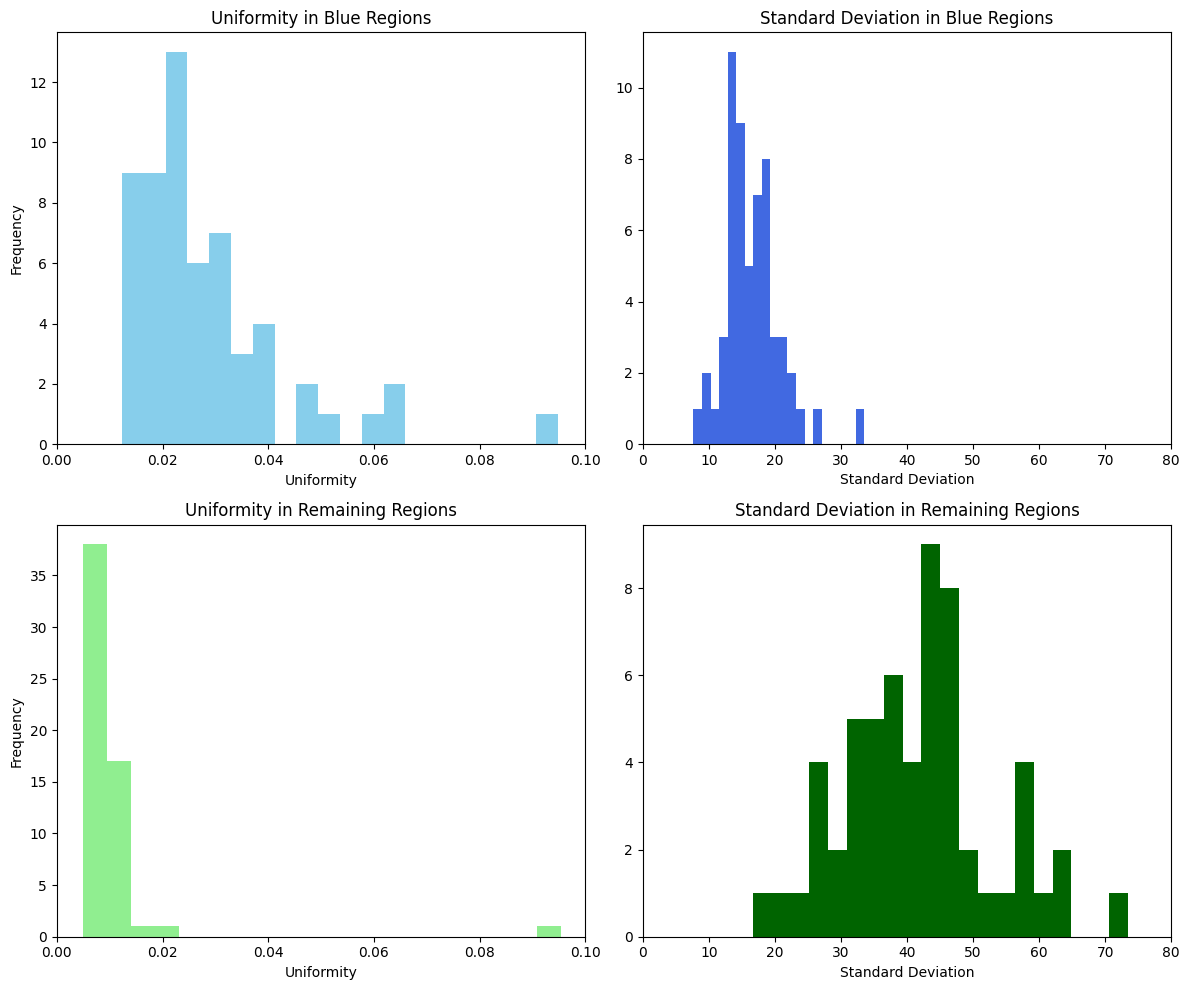

In [68]:
# -----------------------------------------------------
# Q3.1 + Q3.2: Per shape, compute the texture and HOG
# -----------------------------------------------------

hog_results = []
texture_results = []
for img_path in img_paths:
    img_id = Path(img_path).stem
    img, embryo_mask = embryo_segmentaion(img_path)
    img_blue_only = highlight_blue_regions(img)

    img_blue_only[~embryo_mask] = 0

    blue_mask = dip.FixedThreshold(img_blue_only, 120)
    blue_mask = dip.Opening(blue_mask, dip.SE((40,40), "elliptic"))

    remain_mask = dip.Xor(embryo_mask, blue_mask)
    remain_mask = dip.Opening(remain_mask, dip.SE((20,20), "elliptic"))

    # Convert original image to grayscale
    img_gray = dip.ColorSpaceManager.Convert(img, "gray")
    img_gray = convert_to_uint8(img_gray)


    # Compute uniformity and std
    def compute_uniformity_and_std(img, mask):
        mask_values = np.array(img[mask])
        values, counts = np.unique(mask_values, return_counts=True)
        counts = counts / len(mask_values)

        uniformity = (counts ** 2).sum()
        std = np.std(mask_values)

        return uniformity, std
    
    uniformity_blue, std_blue = compute_uniformity_and_std(img_gray, blue_mask)
    uniformity_remain, std_remain = compute_uniformity_and_std(img_gray, remain_mask)
    
    texture_results.append(
        {
            "Image_ID": img_id,
            "Uniformity_Blue": uniformity_blue,
            "Uniformity_Remain": uniformity_remain,
            "Std_Blue": std_blue,
            "Std_Remain": std_remain
        }
    )

    # Compute HOG
    def compute_hog(img, mask, cell_size):
        img_masked = img.Copy()
        img_masked[~mask] = 0
        
        fd, hog_image = hog(img_masked, orientations=8, pixels_per_cell=(cell_size,cell_size), cells_per_block=(1,1),
                         visualize=True, channel_axis=-1)
        return fd, hog_image
    
    fd_blue_16, hog_image_blue_16 = compute_hog(img, blue_mask, 16)
    fd_blue_64, hog_image_blue_64 = compute_hog(img, blue_mask, 64)
    fd_embryo_16, hog_image_embryo_16 = compute_hog(img, embryo_mask, 16)
    fd_embryo_64, hog_image_embryo_64 = compute_hog(img, embryo_mask, 64)

    hog_blue_dir = os.path.join(output_dir, "hog_blue")
    hog_embryo_dir = os.path.join(output_dir, "hog_embryo")
    os.makedirs(hog_blue_dir, exist_ok=True)
    os.makedirs(hog_embryo_dir, exist_ok=True)

    plt.imsave(os.path.join(hog_blue_dir, f"{img_id}_16.png"), cv2.resize(hog_image_blue_16, (0,0), fx=0.25, fy=0.25))
    plt.imsave(os.path.join(hog_blue_dir, f"{img_id}_64.png"), cv2.resize(hog_image_blue_64, (0,0), fx=0.25, fy=0.25))
    plt.imsave(os.path.join(hog_embryo_dir, f"{img_id}_16.png"), cv2.resize(hog_image_embryo_16, (0,0), fx=0.25, fy=0.25))
    plt.imsave(os.path.join(hog_embryo_dir, f"{img_id}_64.png"), cv2.resize(hog_image_embryo_64, (0,0), fx=0.25, fy=0.25))

    combined_hog_feature_vec = np.concatenate((fd_blue_16, fd_blue_64, fd_embryo_16, fd_embryo_64))
    hog_results.append(combined_hog_feature_vec)



texture_features_df = pd.DataFrame(texture_results)
texture_features_df = texture_features_df.set_index("Image_ID")
texture_features_df.to_latex(os.path.join(output_dir, "texture_features.tex"), float_format="%.3f")
display(texture_features_df)

# Generate histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Blue region features
axs[0,0].set_xlim((0, 0.1))
axs[0,0].hist(texture_features_df['Uniformity_Blue'], bins=20, color='skyblue')
axs[0,0].set_title('Uniformity in Blue Regions')
axs[0,0].set_xlabel('Uniformity')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(texture_features_df['Std_Blue'], bins=20, color='royalblue')
axs[0,1].set_xlim((0, 80))
axs[0,1].set_title('Standard Deviation in Blue Regions')
axs[0,1].set_xlabel('Standard Deviation')

# Non-blue region features
axs[1,0].set_xlim((0, 0.1))
axs[1,0].hist(texture_features_df['Uniformity_Remain'], bins=20, color='lightgreen')
axs[1,0].set_title('Uniformity in Remaining Regions')
axs[1,0].set_xlabel('Uniformity')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(texture_features_df['Std_Remain'], bins=20, color='darkgreen')
axs[1,1].set_xlim((0, 80))
axs[1,1].set_title('Standard Deviation in Remaining Regions')
axs[1,1].set_xlabel('Standard Deviation')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'texture_histograms.png'))
plt.show()

# Part 4

In [70]:
# Size and shape features (pandas dataframe)
shape_features_df

# Texture features (pandas dataframe)
texture_features_df

# HOG features (list of vectors. vectors concatinated from 4 HOG calculations)
hog_results

[array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(88064,)),
 array([0.